# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [1346]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure

from mqr.doe import Design

from ht_simNy import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats


### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

## Fractional Factorial Design

In [1347]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f g abc abd ace bcf cde')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.3, 0.03, 0.60, 0.30,0.30]


factor_levels = {
    'rho_l': [2386.20, 2533.8], #A
    'rho_s': [2628.70, 2791.3], #B
    'k_l': [100.88, 107.2],    #C
    'k_s': [93.31,99.08],      #D
    'cp_l': [1207.94, 1282.65], #E
    'cp_s': [934.11, 991.89],  #F
    'Surr_temp': [285.0,298.0], #G
    'L_fusion': [377330,400670], #H
    'temp_init': [901.0, 925.0], # J
    'heat_transfer_coefficient_left': [10.0, 15.0], #K
    'heat_transfer_coefficient_right': [10.0, 15.0], #L
    'Length': [10.0e-3, 20.0e-3],      #M
}


factor_names = list(factor_levels.keys())
# print (313.0 *(1+perc_change[6]))
# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})
   
    
print(doe_df_sol_time_fracfact.shape)

(128, 12)


In [1348]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['Lowest_Niyama'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

print(FracFact_doe_sol_time.shape)



(128, 13)


In [1349]:
for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    if input_values.size > 0:
        k = sim1d(*input_values)
        FracFact_doe_sol_time.at[i, 'Lowest_Niyama'] = k
        

    

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
(10353, 48)
Lowest Niyama:0.01, rho_l

### Histogram of the Total Solidifcation time is plotted

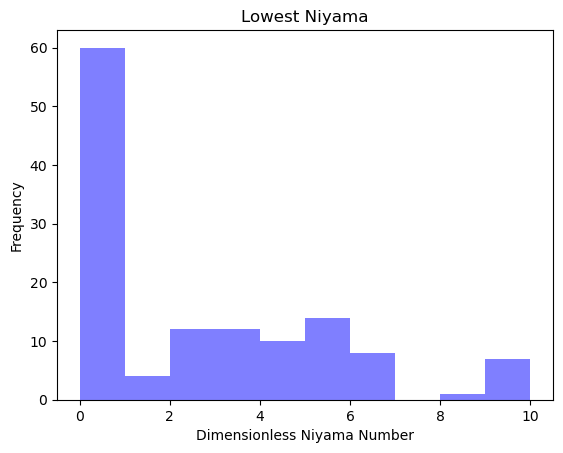

In [1350]:
plt.hist(FracFact_doe_sol_time['Lowest_Niyama'], bins=10, alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Dimensionless Niyama Number')
plt.ylabel('Frequency')
plt.show()

### Regression model is developed

In [1386]:


# Create the formula for the ANOVA
formula = formula5 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s +  \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init +  \
            Surr_temp*Length +  L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()

mqr.anova.coeffs(model5)

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()

mqr.anova.coeffs(model)


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-en

,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,2.073612e-03,-1.395433e-02,1.810155e-02,0.257232,7.976214e-01,0.000000e+00
rho_l,-1.395663e-01,-5.396565e-01,2.605240e-01,-0.693581,4.898359e-01,inf
rho_s,-1.528846e-05,-1.670483e-04,1.364714e-04,-0.200300,8.417241e-01,inf
k_l,-8.658607e-03,-3.701310e-02,1.969589e-02,-0.607157,5.453652e-01,inf
k_s,-8.706824e-01,-6.214940e+00,4.473575e+00,-0.323927,7.467890e-01,1.286743e+15
cp_l,-6.995109e-02,-2.719085e-01,1.320064e-01,-0.688667,4.929080e-01,9.007199e+15
cp_s,-2.798021e-06,-1.011863e-04,9.559028e-05,-0.056543,9.550416e-01,inf
Surr_temp,2.504058e-02,-3.831784e+00,3.881865e+00,0.012909,9.897307e-01,1.132800e+04
L_fusion,4.850447e-04,-3.005622e-03,3.975712e-03,0.276279,7.830043e-01,inf
temp_init,3.573073e-01,-2.030663e+00,2.745278e+00,0.297501,7.668102e-01,9.007199e+15


### Plot of Residuals

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



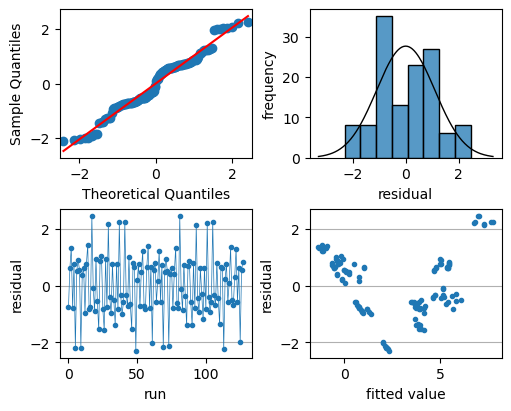

In [1387]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model, axs=ax)
    plot = grab_figure(fig)

hstack( 
    plot,
    vstack(
        mqr.anova.adequacy(model),
        mqr.inference.dist.test_1sample(model.resid)
    )
)
# new code


The interaction was observed among rho_l and cp_s , rho_s and cp_s , cp_l and cp_s  & cp_s and temp_init.

## Center points check

In [1376]:
num_center_points = 1

center_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}

center_pt_df = pd.DataFrame([center_point] * num_center_points, columns=factor_names)

doe_center_pt = pd.concat([doe_df_sol_time_fracfact, center_pt_df], ignore_index=True)


### Factorial design

In [1354]:
Fractional_Factorial_doe_center_pt = doe_center_pt.copy()

Fractional_Factorial_doe_center_pt['Lowest_Niyama'] = [0.0] * Fractional_Factorial_doe_center_pt.shape[0]

print(Fractional_Factorial_doe_center_pt.shape)

(129, 13)


In [1355]:
for i in range(Fractional_Factorial_doe_center_pt.shape[0]):
    input_values = Fractional_Factorial_doe_center_pt.iloc[i,:-1].values
    k= sim1d(*input_values)
    Fractional_Factorial_doe_center_pt.at[i, 'Lowest_Niyama'] = k

    

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
(10353, 48)
Lowest Niyama:0.01, rho_l

In [1380]:
Fractional_Factorial_doe_center_pt['center_pt'] = 0
Fractional_Factorial_doe_center_pt.loc[Fractional_Factorial_doe_center_pt.index[-1],'center_pt'] = 1

CSV file generator

In [1381]:
Fractional_Factorial_doe_center_pt.to_csv('Fractional_Factorial_doe_center_pt.csv', index=False)

### Plot

### Regression Model

In [1385]:
formula5 = 'Lowest_Niyama ~  center_pt + rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s +  \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()

mqr.anova.coeffs(model5)

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pyt

,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,2.073953e-03,-1.395398e-02,1.810189e-02,0.257274,7.975889e-01,0.000000e+00
center_pt,8.492253e-09,-2.319975e-07,2.489820e-07,0.070210,9.441912e-01,NaN
rho_l,-1.395674e-01,-5.396578e-01,2.605229e-01,-0.693587,4.898322e-01,inf
rho_s,-1.486433e-05,-1.670113e-04,1.372826e-04,-0.194248,8.464450e-01,inf
k_l,-8.659004e-03,-3.701349e-02,1.969548e-02,-0.607185,5.453467e-01,inf
k_s,-8.707760e-01,-6.215034e+00,4.473482e+00,-0.323962,7.467627e-01,inf
cp_l,-6.995121e-02,-2.719086e-01,1.320062e-01,-0.688669,4.929071e-01,inf
cp_s,-2.847169e-06,-1.012166e-04,9.552224e-05,-0.057548,9.542440e-01,inf
Surr_temp,2.499535e-02,-3.831829e+00,3.881819e+00,0.012886,9.897493e-01,1.132800e+04
L_fusion,4.849992e-04,-3.005667e-03,3.975665e-03,0.276253,7.830240e-01,inf


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



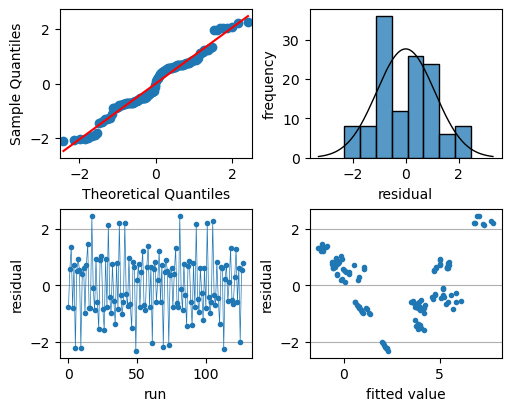

In [1383]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model5, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model5),
        mqr.inference.dist.test_1sample(model5.resid)
    )
)

In [1384]:
# Extracting coefficients (terms) and their p-values
terms = model5.params.index
coefficients = model5.params.values
p_values = model5.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] < p_value_threshold]
print(significant_terms) 

                                                 Term       P-Value
56  heat_transfer_coefficient_left:heat_transfer_c...  1.501955e-32


In [1362]:
formula55 = 'Lowest_Niyama ~ rho_l +rho_s +  heat_transfer_coefficient_left + heat_transfer_coefficient_right +  \
            rho_l*rho_s  \
             +  \
             heat_transfer_coefficient_left*heat_transfer_coefficient_right \
            '

In [1363]:

model55 = sm.OLS.from_formula(formula55, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()
mqr.anova.coeffs(model55)

,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,-231.566007,-492.442381,29.310367,-1.757330,8.139069e-02,1.237466e+06
rho_l,0.124728,0.018757,0.230698,2.330183,2.145277e-02,1.112111e+03
rho_s,0.100948,0.004753,0.197143,2.077591,3.986218e-02,1.112111e+03
heat_transfer_coefficient_left,-4.603312,-5.081628,-4.124997,-19.053250,3.125263e-38,2.600000e+01
heat_transfer_coefficient_right,-4.600062,-5.078378,-4.121747,-19.039798,3.332673e-38,2.600000e+01
rho_l:rho_s,-0.000043,-0.000082,-0.000004,-2.197558,2.988464e-02,2.223222e+03
heat_transfer_coefficient_left:heat_transfer_coefficient_right,0.371700,0.334178,0.409222,19.611818,2.212650e-39,5.100000e+01


In [1364]:
# Extracting coefficients (terms) and their p-values
terms = model55.params.index
coefficients = model55.params.values
p_values = model55.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] > p_value_threshold]
print(significant_terms) 

        Term   P-Value
0  Intercept  0.081391


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



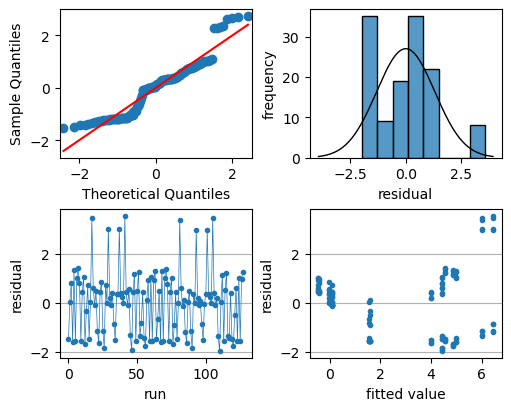

In [1365]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model55, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model55),
        mqr.inference.dist.test_1sample(model55.resid)
    )
)

### Anova Table

#### Main effects with center points

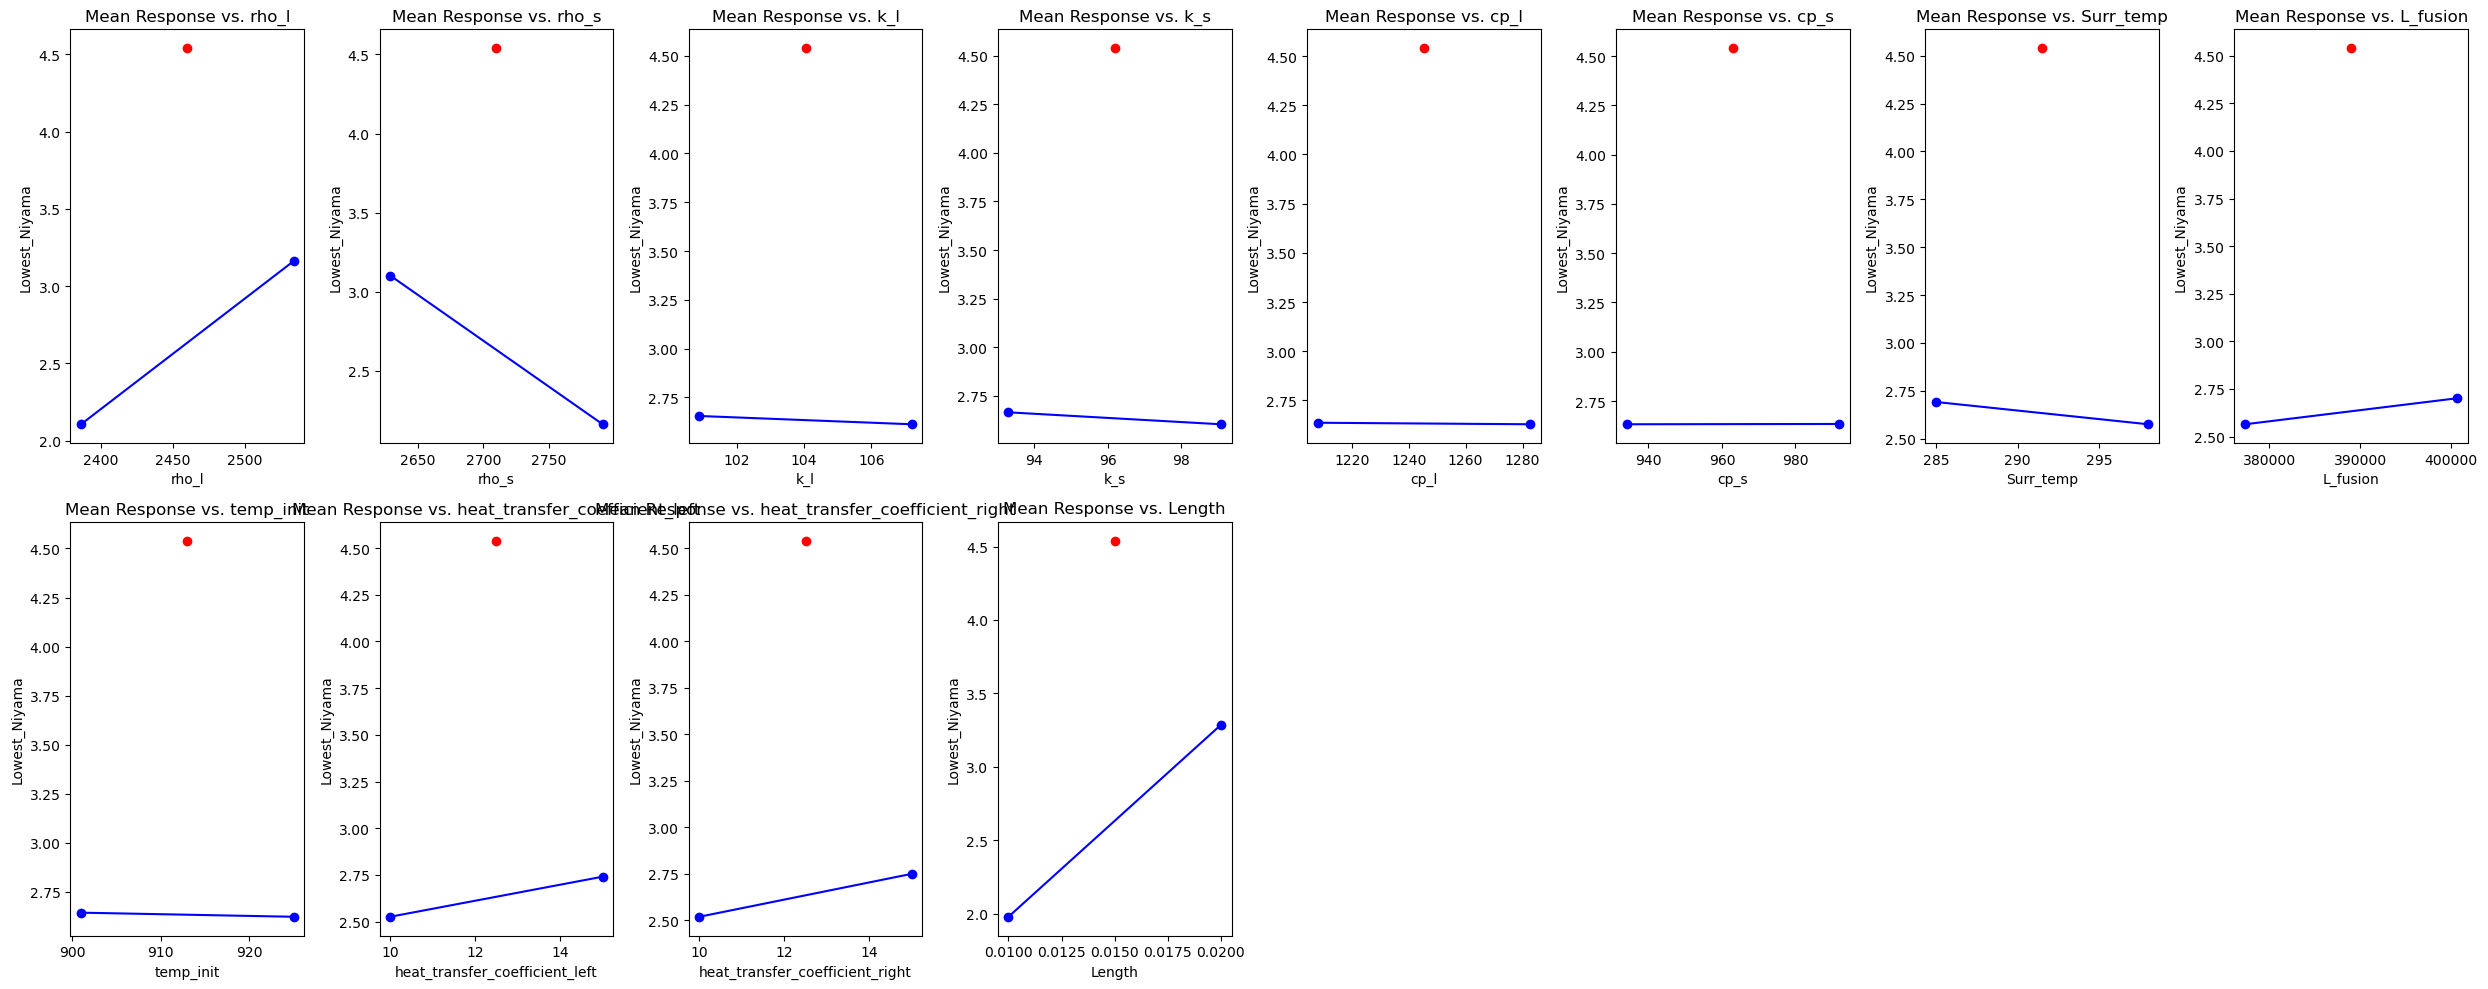

In [1366]:
mean_response_center = {}

for factor in factor_names:
    mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama'].mean()

# print(mean_response_center)
plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 8, i+1)

    mean_responses = mean_response_center[factor]


    center_point = mean_responses.iloc[-2]
    center_point_index = mean_responses.index[-2]
    # print(center_point_index,center)
    non_center_points_low = mean_responses.iloc[0]
    non_center_points_low_index = mean_responses.index[0]
    non_center_points_high = mean_responses.iloc[-1]
    non_center_points_high_index = mean_responses.index[-1]

    plt.plot([non_center_points_low_index,non_center_points_high_index], [non_center_points_low,non_center_points_high],marker='o', color='b')
    
    # Plotting the center points
    center_points = mean_response_center[factor]
    plt.scatter([center_point_index], [center_point], color='r', label='Center Points')
    
    # # Plot all individual data points for the factor
    # all_data_points = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama']
    # for key, group in all_data_points:
    #     plt.scatter([key]*len(group), group, alpha=0.3, color='gray')

    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Lowest_Niyama')

plt.tight_layout()
plt.show()


### interaction terms

   heat_transfer_coefficient_left  heat_transfer_coefficient_right  \
0                            10.0                             10.0   
1                            15.0                             10.0   
2                            10.0                             15.0   
3                            15.0                             15.0   
4                            15.0                             15.0   

   Lowest_Niyama  
0           2.94  
1           1.61  
2           0.39  
3           3.38  
4           6.21  


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The provided callable <function mean at 0x7f609825c9a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data = DataFrame(dict(x=x, trace=trace, response=response))


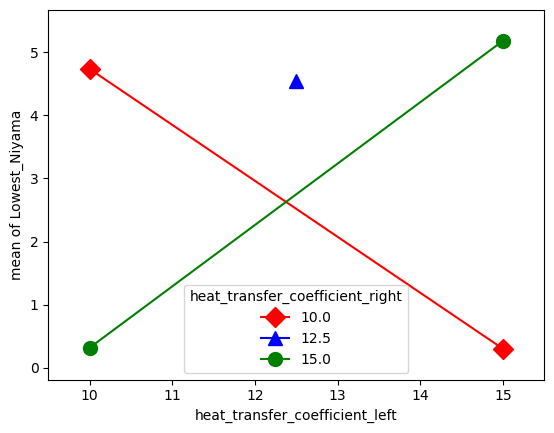

In [1367]:
interaction = pd.DataFrame(Fractional_Factorial_doe_center_pt, columns= ('heat_transfer_coefficient_left','heat_transfer_coefficient_right','Lowest_Niyama'))

print(interaction.head())

from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(interaction['heat_transfer_coefficient_left'], interaction['heat_transfer_coefficient_right'], interaction['Lowest_Niyama'], colors=['red','blue','green'], markers=['D','^','o'], ms=10)
plt.show()





In [1368]:
inter_terms = Fractional_Factorial_doe_center_pt[['heat_transfer_coefficient_left','heat_transfer_coefficient_right','Lowest_Niyama']]
inter_terms['htcl*htcr'] = inter_terms['heat_transfer_coefficient_left'] * inter_terms['heat_transfer_coefficient_right']

col1,col2 = 2,3

columns_list = list(inter_terms.columns)

columns_list[col1], columns_list[col2] = columns_list[col2] , columns_list[col1]

inter_terms = inter_terms[columns_list]

print(inter_terms)

     heat_transfer_coefficient_left  heat_transfer_coefficient_right  \
0                              10.0                             10.0   
1                              15.0                             10.0   
2                              10.0                             15.0   
3                              15.0                             15.0   
4                              15.0                             15.0   
..                              ...                              ...   
124                            10.0                             10.0   
125                            15.0                             10.0   
126                            10.0                             15.0   
127                            15.0                             15.0   
128                            12.5                             12.5   

     htcl*htcr  Lowest_Niyama  
0       100.00           2.94  
1       150.00           1.61  
2       150.00           0.39  
3      

/tmp/ipykernel_269245/3925212017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inter_terms['htcl*htcr'] = inter_terms['heat_transfer_coefficient_left'] * inter_terms['heat_transfer_coefficient_right']


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

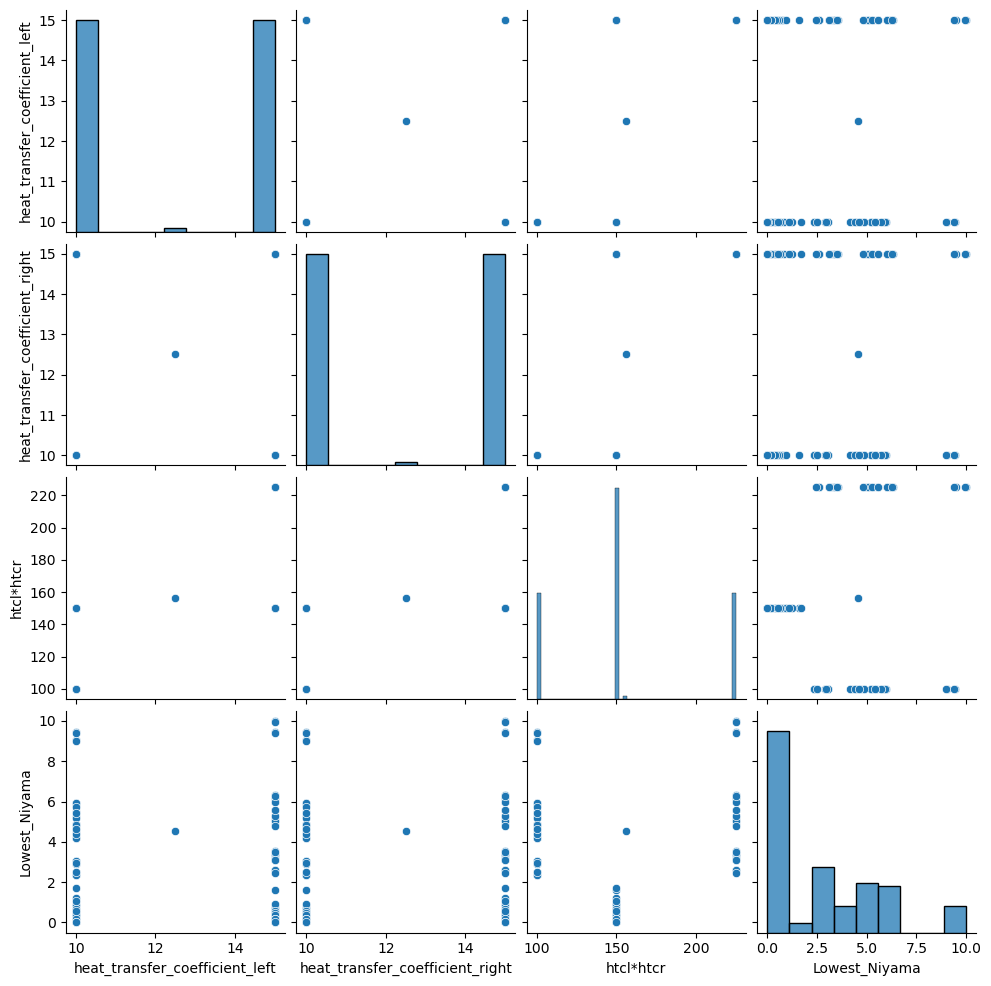

In [1369]:
sns.pairplot(inter_terms)
plt.show()

In [1370]:
import statsmodels.api as sm
import pandas as pd
import itertools

# Define the list of variables
variables = ['rho_l', 'rho_s', 'k_l', 'k_s', 'cp_l', 'cp_s', 'Surr_temp', 'L_fusion', 'temp_init', 'heat_transfer_coefficient_left', 'heat_transfer_coefficient_right', 'Length']

# Generate interaction terms
combinations = list(itertools.combinations(variables, 2))
interaction_terms = ['{}*{}'.format(a, b) for a, b in combinations]

# Generate quadratic (axial) terms
quadratic_terms = ['np.power({}, 2)'.format(var) for var in variables]

# Base formula with main effects
base_formula = 'Lowest_Niyama ~ ' + ' + '.join(variables)

# Combine all terms into the final formula
all_terms = variables + interaction_terms + quadratic_terms
final_formula = 'Lowest_Niyama ~ ' + ' + '.join(all_terms)

# Print the final formula
print("Final Formula for Statsmodels:")
print(final_formula)




Final Formula for Statsmodels:
Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + cp_l + cp_s + Surr_temp + L_fusion + temp_init + heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + rho_l*rho_s + rho_l*k_l + rho_l*k_s + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*temp_init + rho_l*heat_transfer_coefficient_left + rho_l*heat_transfer_coefficient_right + rho_l*Length + rho_s*k_l + rho_s*k_s + rho_s*cp_l + rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion + rho_s*temp_init + rho_s*heat_transfer_coefficient_left + rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*k_s + k_l*cp_l + k_l*cp_s + k_l*Surr_temp + k_l*L_fusion + k_l*temp_init + k_l*heat_transfer_coefficient_left + k_l*heat_transfer_coefficient_right + k_l*Length + k_s*cp_l + k_s*cp_s + k_s*Surr_temp + k_s*L_fusion + k_s*temp_init + k_s*heat_transfer_coefficient_left + k_s*heat_transfer_coefficient_right + k_s*Length + cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*h

## DOE with Axial Points

In [1371]:
axial_points = []

alpha = 1.414

# Calculate the midpoint (center) for each factor
factor_centers = {key: (low + high) / 2 for key, (low, high) in factor_levels.items()}

for factor in factor_levels.keys():
    for direction in [-1,1]:
        axial_point = factor_centers.copy()
        low , high = factor_levels[factor]

        if direction == 1:
            axial_point[factor] = factor_centers[factor] + alpha * (high - factor_centers[factor])
        else:
            axial_point[factor] = factor_centers[factor] - alpha * (factor_centers[factor] - low)
        
        axial_points.append(axial_point)
    


axial_df = pd.DataFrame(axial_points, columns=factor_centers.keys())

comb_df = pd.concat([doe_center_pt, axial_df], axis=0)


comb_df['Lowest_Niyama'] = [0.0] * comb_df.shape[0]
# print(comb_df.iloc[140:])      

In [1372]:
counter = 0
for i in range(comb_df.shape[0]):
    input_values = comb_df.iloc[i,:-1].values
    k = sim1d(*input_values)
    comb_df.at[i, 'Lowest_Niyama'] = k
    counter = counter + 1
    print(counter)

print(comb_df.shape)

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
1
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
2
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
3
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
4
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
5
(10353, 48)
Lowest Niyama:0

KeyboardInterrupt: 

In [ ]:
print(comb_df.shape)
comb_df.to_csv('comb_df.csv', index=False)

In [ ]:
print(comb_df.shape)

(153, 13)


### Study of interaction and quadratic effects


In [ ]:
formula11 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion  + rho_s*heat_transfer_coefficient_left + \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init + Surr_temp*heat_transfer_coefficient_left +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length + np.power(rho_l, 2) + \
                np.power(rho_s, 2) + np.power(k_l, 2) + np.power(k_s, 2) + np.power(cp_l, 2) + np.power(cp_s, 2) + \
             np.power(Surr_temp, 2) + np.power(L_fusion, 2) + np.power(temp_init, 2) + np.power(heat_transfer_coefficient_left, 2) + \
                np.power(heat_transfer_coefficient_right, 2) + np.power(Length, 2)'

In [ ]:
print(comb_df.shape)
model10 = sm.OLS.from_formula(formula11, data=comb_df).fit()
mqr.anova.coeffs(model10)

(153, 13)


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-en

,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,0.0,0.0,0.0,NaN,NaN,0.000000e+00
rho_l,0.0,0.0,0.0,NaN,NaN,inf
rho_s,0.0,0.0,0.0,NaN,NaN,inf
k_l,0.0,0.0,0.0,NaN,NaN,inf
k_s,0.0,0.0,0.0,NaN,NaN,1.257971e+11
...,...,...,...,...,...,...
"np.power(L_fusion, 2)",0.0,0.0,0.0,NaN,NaN,6.754031e+04
"np.power(temp_init, 2)",0.0,0.0,0.0,NaN,NaN,3.492310e+05
"np.power(heat_transfer_coefficient_left, 2)",0.0,0.0,0.0,NaN,NaN,1.510767e+03
"np.power(heat_transfer_coefficient_right, 2)",0.0,0.0,0.0,NaN,NaN,1.510767e+03


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1870: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/home/student.unimelb.e


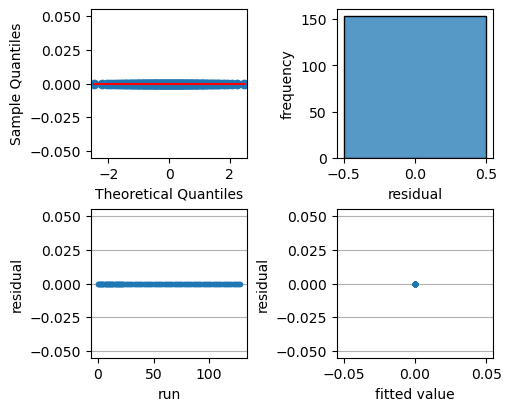

In [ ]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model10, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model10),
        mqr.inference.dist.test_1sample(model10.resid)
    )
)

In [ ]:
# Extracting coefficients (terms) and their p-values
terms = model10.params.index
coefficients = model10.params.values
p_values = model10.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] < p_value_threshold]
print(significant_terms)  

Empty DataFrame
Columns: [Term, P-Value]
Index: []


In [ ]:
formula12 ='Lowest_Niyama ~   cp_l +    \
            heat_transfer_coefficient_right + Length + \
                      +  \
                         \
                           \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right '

In [ ]:
model11 = sm.OLS.from_formula(formula12, data=comb_df).fit()

mqr.anova.coeffs(model11)

,Coeff,[2.5%,97.5%],t,PR(>|t|),VIF
Intercept,0.0,0.0,0.0,NaN,NaN,2104.613363
cp_l,0.0,0.0,0.0,NaN,NaN,1.000000
heat_transfer_coefficient_right,0.0,0.0,0.0,NaN,NaN,26.781014
Length,0.0,0.0,0.0,NaN,NaN,1.000000
heat_transfer_coefficient_left,0.0,0.0,0.0,NaN,NaN,26.781014
heat_transfer_coefficient_left:heat_transfer_coefficient_right,0.0,0.0,0.0,NaN,NaN,52.562028


In [ ]:
# Extracting coefficients (terms) and their p-values
terms = model11.params.index
coefficients = model11.params.values
p_values = model11.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.06
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] > p_value_threshold]
print(significant_terms)  

   Term   P-Value
1  cp_l  0.680685


/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



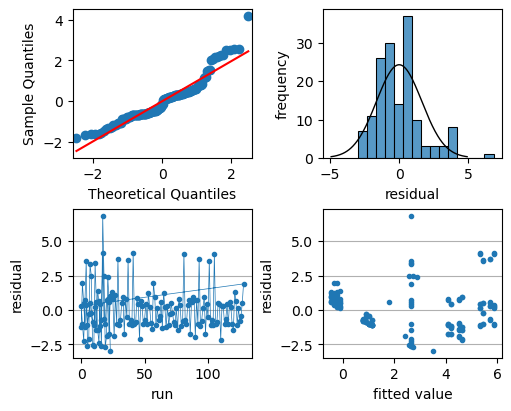

In [ ]:

with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(model11, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    vstack(
        mqr.anova.adequacy(model11),
        mqr.inference.dist.test_1sample(model11.resid)
    )
)

In [ ]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(resid66)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.940817555392238
p-value: 4.9949898118058375e-06
The residuals are not normally distributed (reject H0).


In [ ]:
anova_table = sm.stats.anova_lm(model11, typ=2)
print(anova_table)

                                                        sum_sq     df  \
cp_l                                                  0.470545    1.0   
heat_transfer_coefficient_right                       3.519232    1.0   
Length                                               49.737553    1.0   
heat_transfer_coefficient_left                        0.328521    1.0   
heat_transfer_coefficient_left:heat_transfer_co...  690.804450    1.0   
Residual                                            406.809331  147.0   

                                                             F        PR(>F)  
cp_l                                                  0.170031  6.806850e-01  
heat_transfer_coefficient_right                       1.271670  2.612909e-01  
Length                                               17.972597  3.942321e-05  
heat_transfer_coefficient_left                        0.118711  7.309297e-01  
heat_transfer_coefficient_left:heat_transfer_co...  249.621251  1.712299e-33  
Residual      

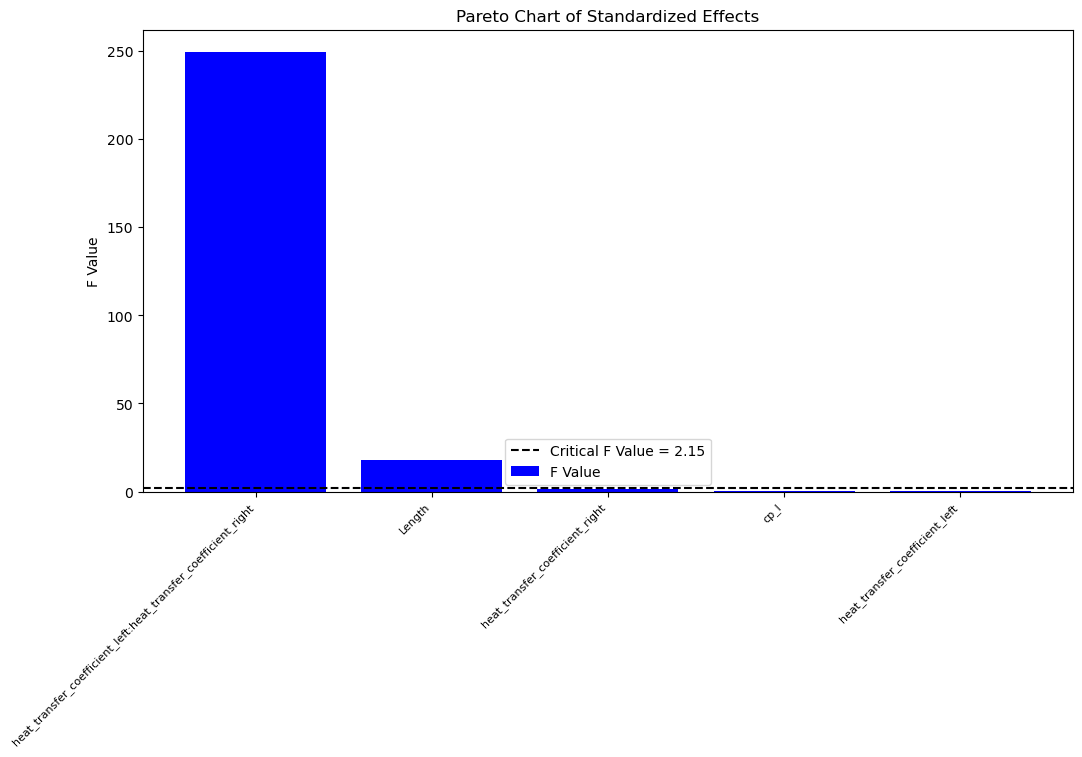

In [ ]:
# Pareto Plot from anova_table

# Extract the F-statistic and p-value from the ANOVA table
f_statistic = anova_table['F'].values

p_values = anova_table['PR(>F)'].values

# Calculate the critical F-value
alpha = 0.05
num_total_points = comb_df.shape[0]
num_terms = len(p_values)
critical_f_value = stats.f.ppf(q=1-alpha, dfn=num_terms, dfd=num_total_points-num_terms)

# Create a DataFrame for the Pareto plot
pareto_df = pd.DataFrame({
    'Term': anova_table.index,
    'F Value': f_statistic,
    'P Value': p_values
})

# Sort the DataFrame by the absolute F-value in descending order
pareto_df = pareto_df.reindex(pareto_df['F Value'].abs().sort_values(ascending=False).index)

# Calculate the cumulative sum of the F-values
pareto_df['Cumulative F Value'] = pareto_df['F Value'].cumsum()

# Create a mask for the significant terms
significant_mask = pareto_df['P Value'] < alpha

# Plot the Pareto chart
plt.figure(figsize=(12, 6))
plt.bar(pareto_df['Term'], pareto_df['F Value'], color='b', label='F Value')
plt.axhline(critical_f_value, color='k', linestyle='--', label='Critical F Value = {:.2f}'.format(critical_f_value))
plt.xticks(fontsize= 8,rotation=45, ha='right')
plt.legend()
plt.title('Pareto Chart of Standardized Effects')
plt.ylabel('F Value')
plt.show()






In [ ]:
condition = pareto_df['F Value'] > critical_f_value

result = pareto_df.loc[condition, ['Term', 'F Value', 'P Value']]

fscore_df = result[['Term','F Value']]

print(fscore_df)

                                                Term     F Value
4  heat_transfer_coefficient_left:heat_transfer_c...  249.621251
2                                             Length   17.972597
